# Advanced lane finding

In [1]:
import matplotlib
import numpy as np
import cv2
import os, fnmatch
import collections
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.pipeline import Pipeline

from scipy.signal import butter, lfilter, lfilter_zi

## Compute camera calibration from chessboard images

In [2]:
# Get a list of calibration images
camera_cal_folder = 'camera_cal'
camera_cal_files = []
for file_name in os.listdir(camera_cal_folder):
    if fnmatch.fnmatch(os.path.join(camera_cal_folder, file_name), '*.jpg'):
        camera_cal_files.append(os.path.join(camera_cal_folder, file_name))

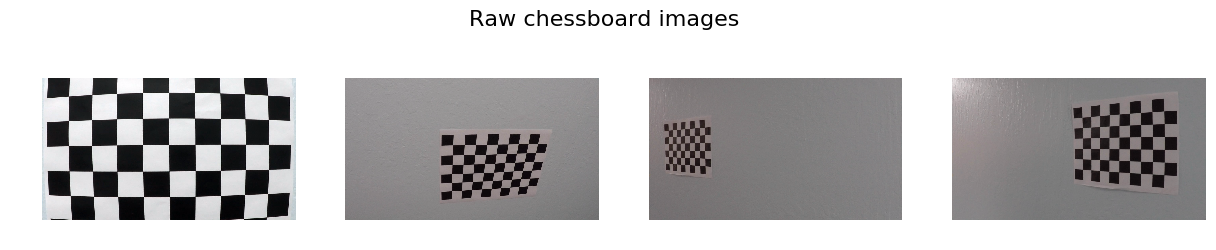

In [3]:
# Display some of the calibration images
fig = plt.figure(figsize=(15, 3))
for idx, cal_file in enumerate(camera_cal_files[:4]):
    ax = fig.add_subplot(1, 4, idx+1)
    chess_img = cv2.imread(cal_file)
    ax.imshow(chess_img)
    ax.set_axis_off()
fig.suptitle('Raw chessboard images', fontsize=16)
fig.savefig('output_images/raw_chessboards.png')

In [4]:
# Pipeline to compute calibration from an individual image
def calibrate_camera(img_path):
    # Load image
    img = cv2.imread(img_path)
    img_size = (img.shape[1], img.shape[0])
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Identify chessboard corners, ideally 9x6 but fewer if the chessboard extends out of frame
    n_corners = [(9, 6), (8, 6), (9, 5), (8, 5)]
    corners = None
    for n_corner in n_corners:
        ret, corners = cv2.findChessboardCorners(gray, n_corner, None)
        if ret:
            break
    if not ret:
        raise ValueError('Unable to find corners')
    # Prepare objpoints and imgpoints for calibration
    objpoints = np.zeros((n_corner[0]*n_corner[1], 3), np.float32)
    objpoints[:,:2] = np.mgrid[0:n_corner[0], 0:n_corner[1]].T.reshape(-1,2)
    objpoints = [objpoints]
    imgpoints = [corners]
    # Run the calibration
    rms, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    if rms:
        return mtx, dist
    else:
        raise ValueError('Unable to compute camera calibration')

In [5]:
# Compute calibration on first image, as this fills the frame
mtx, dist = calibrate_camera(camera_cal_files[0])

## Apply distortion correction to raw images

In [6]:
# Function to undistort image given mtx and dist
def undistort_img(img, m, d):
    # Undistort image
    undistort_img = cv2.undistort(img, m, d, None, m)
    return undistort_img

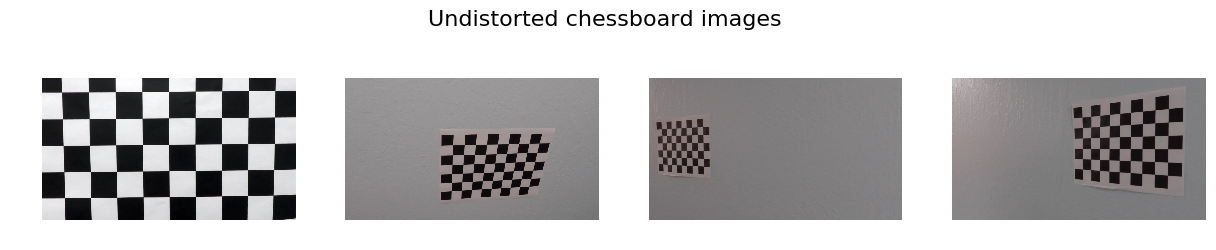

In [7]:
# Display some of the undistorted images
fig = plt.figure(figsize=(15, 3))
for idx, cal_file in enumerate(camera_cal_files[:4]):
    ax = fig.add_subplot(1, 4, idx+1)
    chess_img = cv2.imread(cal_file)
    chess_img = undistort_img(chess_img, mtx, dist)
    ax.imshow(chess_img)
    ax.set_axis_off()
fig.suptitle('Undistorted chessboard images', fontsize=16)
fig.savefig('output_images/undist_chessboards.png')

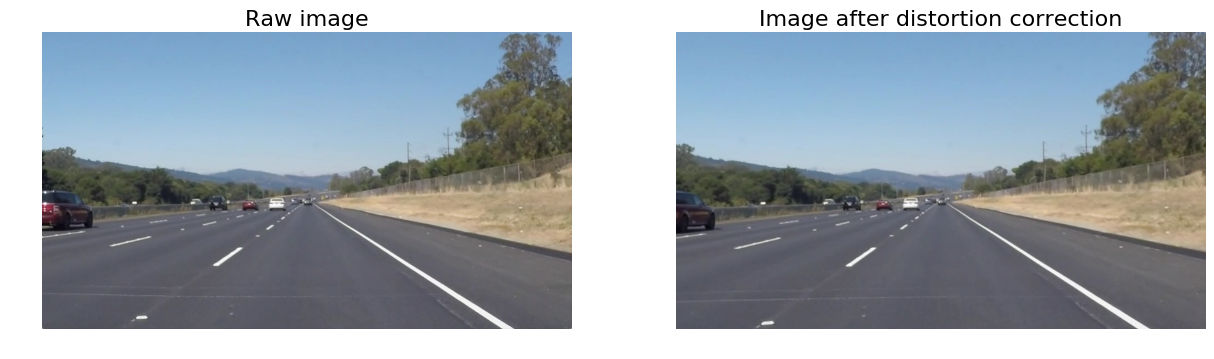

In [8]:
# Display a sample road image, before and after distortion correction
fig = plt.figure(figsize=(15, 4))
test_img = cv2.resize(cv2.imread('test_images/solidWhiteRight.jpg'), (1280, 720))[:,:,-1::-1]

ax = fig.add_subplot(1, 2, 1)
ax.imshow(test_img)
ax.set_axis_off()
ax.set_title('Raw image', fontsize=16)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(undistort_img(test_img, mtx, dist))
ax.set_axis_off()
ax.set_title('Image after distortion correction', fontsize=16)

fig.savefig('output_images/distortion_correction.png')

## Calculate perspective transform

In [9]:
# Load a test image and undistort
test_img = cv2.resize(cv2.imread('test_images/solidWhiteRight.jpg'), (1280, 720))
test_img = undistort_img(test_img, mtx, dist)
_ = cv2.imwrite('ouput_images/solidWhiteRight_undistorted.jpg', test_img)

In [10]:
# Function to draw a semi-transparent polygon on an image
def draw_poly(img, points):
    overlay = img.copy()
    original = img.copy()
    overlay = cv2.fillPoly(overlay, np.int32([points]), (0, 255, 0))
    return cv2.addWeighted(overlay, 0.3, original, 1 - 0.3, 0, original)

In [11]:
# Draw a rectangle corresponding to the lanes
src = np.array([[205, 720], [1131, 720], [821, 523], [479, 523]], np.float32)
annotated_test_img = draw_poly(test_img, src)
_ = cv2.imwrite('output_images/solidWhiteRight_annotated.jpg', annotated_test_img)

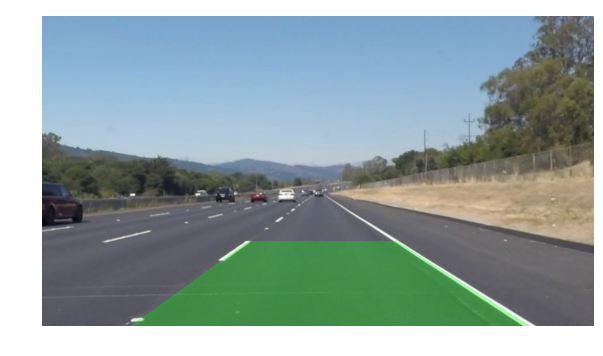

In [12]:
# Display annotated test image
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.imshow(annotated_test_img[:,:,2::-1])
ax.set_axis_off()

fig.savefig('output_images/before_perspective_transform.png')

In [13]:
# Compute perspective transform
dst = np.array([[205, 720], [1131, 720], [1131, 475], [205, 475]], np.float32)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [14]:
# Warp the test image
def perspective_transform(img, M_warp):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M_warp, img_size, flags=cv2.INTER_LINEAR)

In [15]:
warped_test_img = perspective_transform(test_img, M)

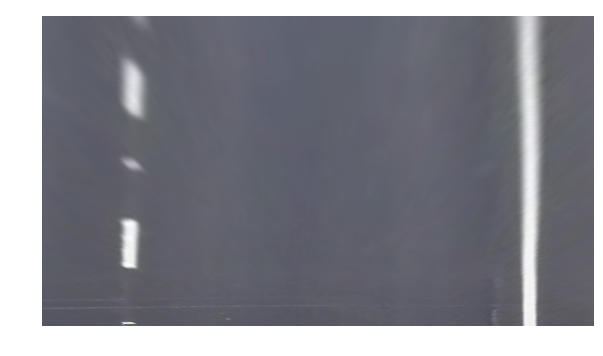

In [16]:
# Display annotated warped test image
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.imshow(warped_test_img[:,:,2::-1])
ax.set_axis_off()

fig.savefig('output_images/after_perspective_transform.png')

## Create thresholded image with lane markings

In [17]:
# Get a list of test images
test_img_folder = 'test_images'
test_files = []
for file_name in os.listdir(test_img_folder):
    if fnmatch.fnmatch(os.path.join(test_img_folder, file_name), '*.jpg'):
        test_files.append(os.path.join(test_img_folder, file_name))

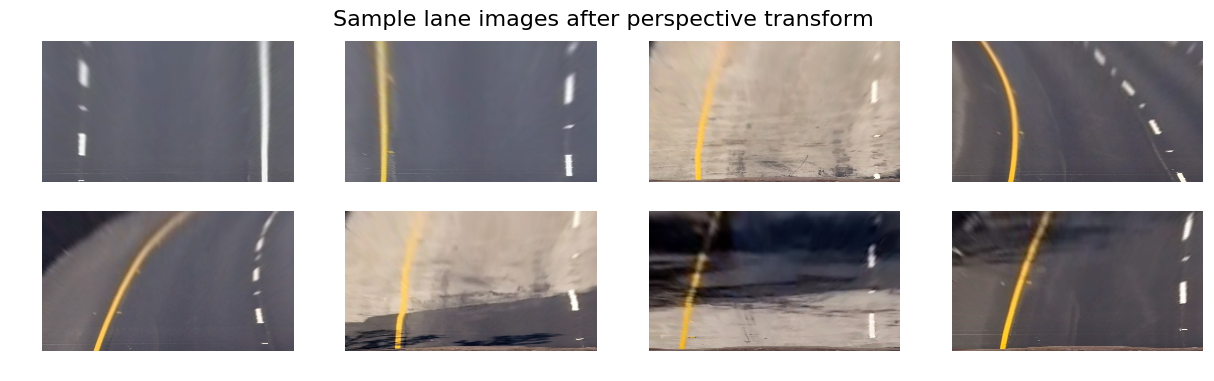

In [18]:
# Display each test image after perspective transform
fig = plt.figure(figsize=(15, 4))
for idx, test_file in enumerate(test_files):
    ax = fig.add_subplot(2, len(test_files)/2, idx+1)
    test_img = cv2.resize(cv2.imread(test_file), (1280, 720))
    test_img = undistort_img(test_img, mtx, dist)
    test_img = perspective_transform(test_img, M)
    ax.imshow(test_img[:,:,2::-1])
    ax.set_axis_off()
    
fig.suptitle('Sample lane images after perspective transform', fontsize=16)
fig.savefig('output_images/line_finding_1.png')

In [19]:
# Gradient computations
def sobel_gradient(img, orient='x', sobel_kernel=3, absolute=False):
    # Calculate sobel gradient
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    assert sobel_kernel % 2 == 1
    if orient.lower() == 'x':
        gradient = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        gradient = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    if absolute:
        return np.absolute(gradient)
    else:
        return gradient

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    abs_sobel = sobel_gradient(img, orient, sobel_kernel, absolute=True)
    # Apply threshold
    return (abs_sobel >= min(thresh)) & (abs_sobel <= max(thresh))

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    abs_sobelx = sobel_gradient(img, 'x', sobel_kernel, absolute=True)
    abs_sobely = sobel_gradient(img, 'y', sobel_kernel, absolute=True)
    magnitude = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    # Apply threshold
    return (magnitude >= min(thresh)) & (magnitude <= max(thresh))

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    abs_sobelx = sobel_gradient(img, 'x', sobel_kernel, absolute=True)
    abs_sobely = sobel_gradient(img, 'y', sobel_kernel, absolute=True)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # Apply threshold
    return (direction >= min(thresh)) & (direction <= max(thresh))

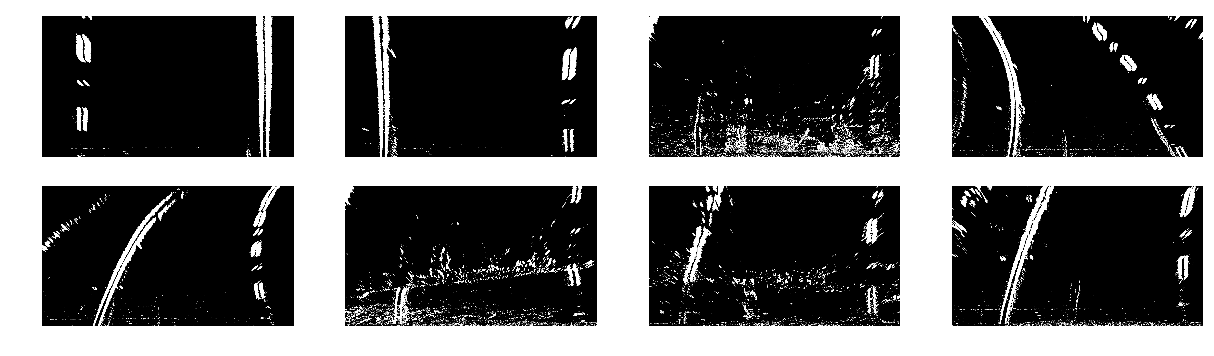

In [20]:
# Play with different gradient operations
fig = plt.figure(figsize=(15, 4))
for idx, test_file in enumerate(test_files):
    ax = fig.add_subplot(2, len(test_files)/2, idx+1)
    test_img = cv2.resize(cv2.imread(test_file), (1280, 720))
    test_img = undistort_img(test_img, mtx, dist)
    test_img = perspective_transform(test_img, M)
    #test_img = abs_sobel_thresh(test_img, orient='x', sobel_kernel=3, thresh=(10, 255))
    test_img = abs_sobel_thresh(test_img, thresh=(10, 255))
    ax.imshow(test_img, cmap='gray')
    ax.set_axis_off()

In [21]:
# Colour space conversions and thresholding
def color_channels(img, channels=['r', 'g', 'b', 'h', 's', 'v']):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    selected = [['r', 'g', 'b', 'h', 's', 'v'].index(s.lower()) for s in channels]
    return np.dstack([rgb, hsv])[:,:,selected]

def color_thresh(img, channels=['r', 'g', 's', 'v'], thresh=(0, 255)):
    avged = np.mean(color_channels(img, channels), axis=2)
    return (avged >= min(thresh)) & (avged <= max(thresh))

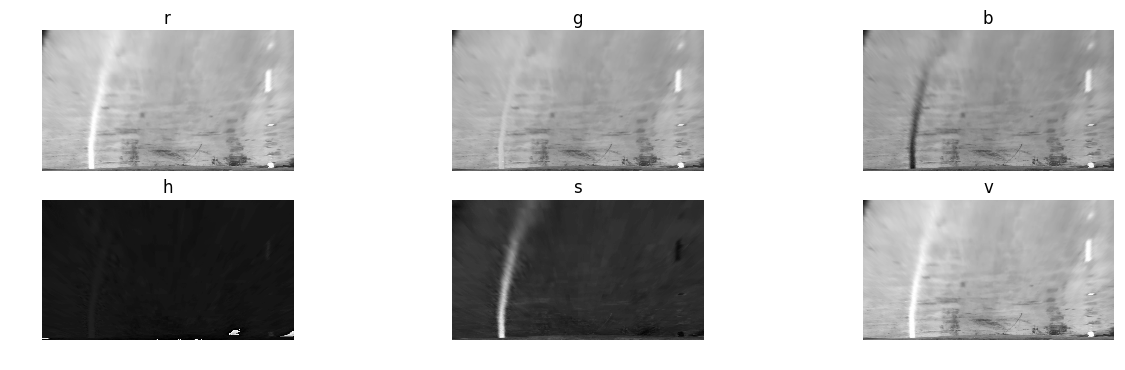

In [22]:
# Display a test image in separate RGB and HSV
fig = plt.figure(figsize=(15, 4))
test_img = cv2.resize(cv2.imread(test_files[2]), (1280, 720))
test_img = undistort_img(test_img, mtx, dist)
test_img = perspective_transform(test_img, M)
test_img = color_channels(test_img)
titles = ['r', 'g', 'b', 'h', 's', 'v']

for idx in range(6):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.imshow(test_img[:,:,idx], cmap='gray')
    ax.set_title(titles[idx])
    ax.set_axis_off()

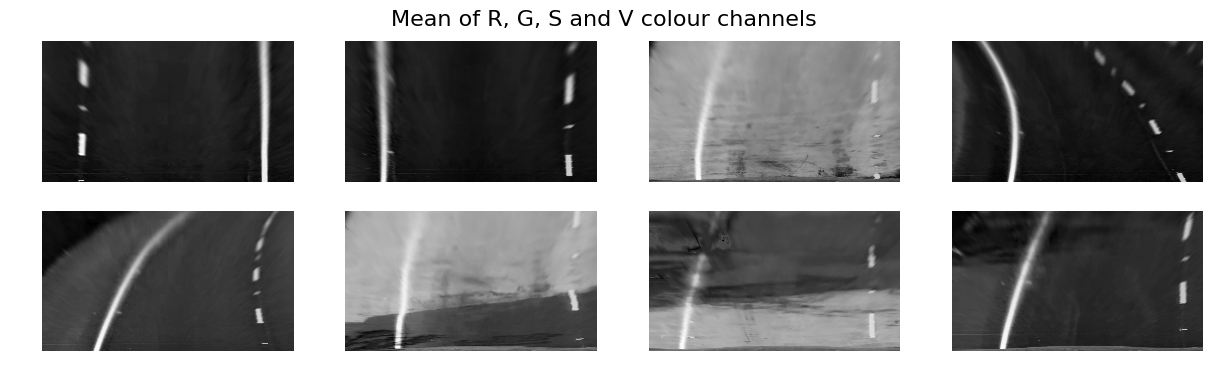

In [23]:
# Play with different colour spaces and thresholds
fig = plt.figure(figsize=(15, 4))
for idx, test_file in enumerate(test_files):
    ax = fig.add_subplot(2, len(test_files)/2, idx+1)
    test_img = cv2.resize(cv2.imread(test_file), (1280, 720))
    test_img = undistort_img(test_img, mtx, dist)
    test_img = perspective_transform(test_img, M)
    test_img = np.mean(color_channels(test_img, channels=['r','g','s','v']), axis=2)
    ax.imshow(test_img, cmap='gray')
    ax.set_axis_off()

fig.suptitle('Mean of R, G, S and V colour channels', fontsize=16)
fig.savefig('output_images/line_finding_2.png')

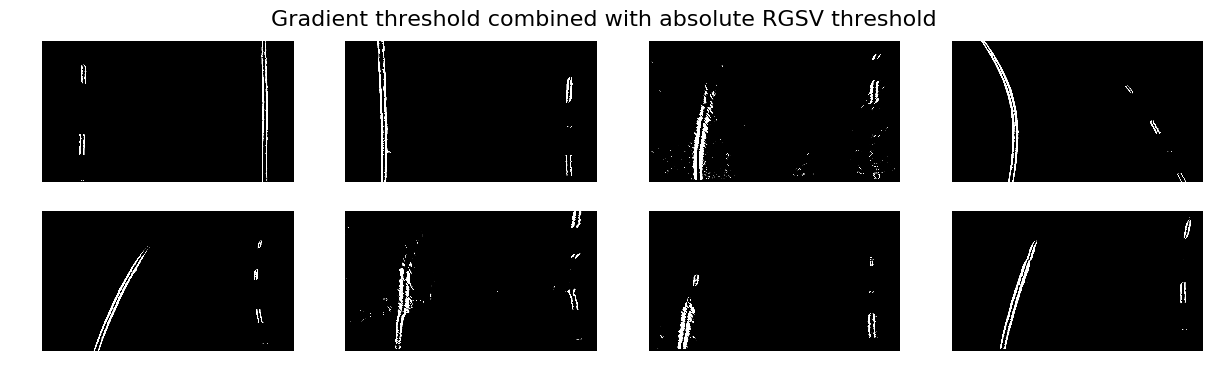

In [24]:
# Colour transform and gradient thresholding combined
fig = plt.figure(figsize=(15, 4))
for idx, test_file in enumerate(test_files):
    ax = fig.add_subplot(2, len(test_files)/2, idx+1)
    test_img = cv2.resize(cv2.imread(test_file), (1280, 720))
    test_img = undistort_img(test_img, mtx, dist)
    test_img = perspective_transform(test_img, M)
    # Select R, G, S, V channels
    rgsv_img = np.mean(color_channels(test_img, channels=['r','g','s','v']), axis=2)
    # Do gradient detection
    thresholded_img = abs_sobel_thresh(rgsv_img, thresh=(10, 255))
    # Combine with thresholded RGSV image
    thresholded_img = thresholded_img & (rgsv_img > 150)
    ax.imshow(thresholded_img, cmap='gray')
    ax.set_axis_off()
    
fig.suptitle('Gradient threshold combined with absolute RGSV threshold', fontsize=16)
fig.savefig('output_images/line_finding_3.png')

## Identify each lane and fit curve

In [25]:
def fit_lanes(x, y):
    # Fit a quadratic: f(y) = Ay**2 + By + C
    # Use RANSAC regression to be robust against outliers
    model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                      ('linear', RANSACRegressor(LinearRegression(fit_intercept=False)))])
    model = model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    return model.named_steps['linear'].estimator_.coef_.flatten()

def residual(x, y, coefs):
    # Return errors of y versus prediction based on x
    predictions = coefs[0] + coefs[1] * x + coefs[2] * x**2
    return y - predictions

def find_lanes_fast(img, X, previous_coefs, pixel_width):
    # Check we actually have a previous line
    if previous_coefs is None:
        raise ValueError('No previous line detected')
    # Find lanes by searching around previous line
    left_points = X[np.absolute(residual(X[:,0], X[:,1], previous_coefs['left'])) <= pixel_width,:]
    right_points = X[np.absolute(residual(X[:,0], X[:,1], previous_coefs['right'])) <= pixel_width,:]
    if (len(left_points) < 50) | (len(right_points) < 50):
        raise ValueError('Not enough points to fit lane lines')
    # Fit new lines to the points
    coefs = {}
    coefs['left'] = fit_lanes(left_points[:,0], left_points[:,1])
    coefs['right'] = fit_lanes(right_points[:,0], right_points[:,1])
    return coefs

def find_lanes_clustering(img, X):
    # Check we have at least 200 points, otherwise raise error
    if len(X) < 200:
        raise ValueError('Not enough points to identify lane lines by clustering')
    # Squeeze vertical dimension to make the clusters smaller
    X_rescaled = X.copy()
    X_rescaled[:,0] = X_rescaled[:,0]*0.1
    km = KMeans(2).fit(X_rescaled)
    # Identify clusters in image
    cluster_img = []
    coefs = []
    for cluster_id in range(max(km.labels_) + 1):
        new_img = np.zeros(img.shape)
        selected = X[km.labels_ == cluster_id,:]
        new_img[selected[:,0], selected[:,1]] = 1
        cluster_img.append(new_img)
        # Fit a line to each cluster
        coefs.append(fit_lanes(selected[:,0], selected[:,1]))
    # Prepare output image containing clusters in separate channels
    cluster_img = np.dstack(cluster_img)
    # Identify left and right coefficients from the intercept term
    if coefs[0][0] < coefs[1][0]:
        coefs = {'left': coefs[0], 'right': coefs[1]}
    else:
        coefs = {'left': coefs[1], 'right': coefs[0]}
    return coefs, cluster_img

def find_lanes(img, previous_coefs=None):
    # Build a list of x, y coords for each of the points in the image
    x, y = np.nonzero(img)
    X = np.array(list(zip(x, y)), dtype=np.int32)
    total_points = np.sum(img)
    if total_points == 0:
        raise ValueError('No features detected in image')
    # First try to find the line within 100 pixels either side of the last one
    try:
        coefs = find_lanes_fast(img, X, previous_coefs, 100)
    except ValueError:
        pass
    else:
        return coefs, None
    # Otherwise try to find lines by clustering 
    try:
        coefs, cluster_img = find_lanes_clustering(img, X)
    except ValueError:
        # Failed completely, so raise exception
        raise
    else:
        return coefs, cluster_img
    
def draw_lines(img, coefs):
    # Draw lines on img
    y = np.arange(img.shape[0])
    x_left = coefs['left'][0] + \
                coefs['left'][1] * y + \
                coefs['left'][2] * y**2
    x_right = coefs['right'][0] + \
                coefs['right'][1] * y + \
                coefs['right'][2] * y**2
    # Clip the values to fit in the image frame
    x_left = np.clip(np.int32(x_left), 3, img.shape[1] - 4)
    x_right = np.clip(np.int32(x_right), 3, img.shape[1] - 4)
    # Draw the line 7 pixels wide
    for offset in np.arange(-3, 4):
        img[y, x_left + offset] = 1
        img[y, x_right + offset] = 1
    return img
    

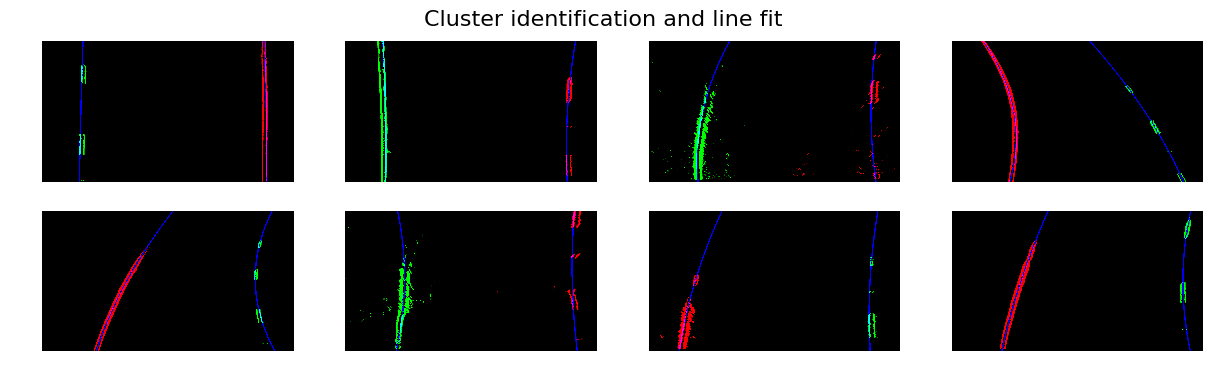

In [26]:
# Plot clusters
fig = plt.figure(figsize=(15, 4))
for idx, test_file in enumerate(test_files):
    ax = fig.add_subplot(2, len(test_files)/2, idx+1)
    test_img = cv2.resize(cv2.imread(test_file), (1280, 720))
    test_img = undistort_img(test_img, mtx, dist)
    test_img = perspective_transform(test_img, M)
    # Select R, G, S, V channels
    rgsv_img = np.mean(color_channels(test_img, channels=['r','g','s','v']), axis=2)
    # Do gradient detection
    thresholded_img = abs_sobel_thresh(rgsv_img, thresh=(10, 255))
    # Combine with thresholded RGSV image
    thresholded_img = thresholded_img & (rgsv_img > 150)
    coefficients, clusters = find_lanes(thresholded_img)
    ax.imshow(np.dstack([clusters, draw_lines(np.zeros(thresholded_img.shape), coefficients)]))
    ax.set_axis_off()
    
fig.suptitle('Cluster identification and line fit', fontsize=16)
fig.savefig('output_images/line_fit.png')

## Full pipeline to process video frames

The code below defines a `Line` class to store characteristics of each lane line, and a `Filter` class to implement low-pass filtering of the line coefficients.

In [27]:
class Filter():
    def __init__(self, sample_frequency, cutoff_frequency):
        nyquist_frequency = 0.5*sample_frequency
        normal_cutoff = cutoff_frequency / nyquist_frequency
        self.b, self.a = butter(6, normal_cutoff, btype='low', analog=False)
        # Create buffer to hold history of x
        self.x = collections.deque(maxlen=len(self.b) - 1)
        # Filter state
        self.z = None
    
    def update(self, x):
        if self.z is None:
            # Perform initial setup on the filter
            _ = [self.x.append(x) for idx in range(len(self.b) - 1)]
            # Setup for steady initial state
            self.z = lfilter_zi(self.b, self.a)*x
        # Put new x into buffer
        self.x.append(x)
        # Filter
        y, zf = lfilter(self.b, self.a, np.float32(self.x), zi=self.z)
        # Store filter state
        self.z = zf
        # Return final value
        return y[-1]
        
        
class Line():
    def __init__(self, **kwargs):
        # Store parameters for future use
        self.settings = kwargs
        # Coefficients
        self.coefficients = None
        # Low pass Butterworth filters to smooth out updates
        self.filters = [Filter(self.settings['fps'], self.settings['cutoff']),
                        Filter(self.settings['fps'], self.settings['cutoff']),
                        Filter(self.settings['fps'], self.settings['cutoff'])]
        self.history = []
        
    def radius_of_curvature(self):
        # Returns curvature radius in metres at bottom of image
        if self.coefficients is None:
            return 0
        # Re-fit lines in metres instead of pixels
        coords = self.coords()
        coords[:,0] = coords[:,0] / self.settings['x_pixels_per_metre']
        coords[:,1] = coords[:,1] / self.settings['y_pixels_per_metre']
        fit_cr = np.polyfit(coords[:,1], coords[:,0], 2)
        r = ((1 + (2 * fit_cr[0] * self.settings['shape'][1] / self.settings['y_pixels_per_metre'] + 
                   fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return r 
    
    def intercept(self):
        # Returns line intercept in metres at bottom of image
        intercept = self.coefficients[0] + \
                    self.coefficients[1] * self.settings['shape'][1] + \
                    self.coefficients[2] * self.settings['shape'][1]**2
        return intercept / self.settings['x_pixels_per_metre']
    
    def upper_intercept(self):
        # Returns line intercept in metres at top of image
        intercept = self.coefficients[0]
        return intercept / self.settings['x_pixels_per_metre']
    
    def coords(self):
        # Return array of x and y coordinates of the lane line
        if self.coefficients is None:
            return None
        else:
            y = np.arange(self.settings['shape'][1]).reshape(-1, 1)
            x = self.coefficients[0] + \
                self.coefficients[1] * y + \
                self.coefficients[2] * y**2
            return np.hstack((x, y))
    
    def update(self, coefficients):
        if coefficients is None:
            return
        if self.settings['filter_coefficients']:
            filtered_coefficients = []
            # Filter each coefficient before storing
            for idx, f in enumerate(self.filters):
                filtered_coefficients.append(f.update(coefficients[idx]))
            self.coefficients = filtered_coefficients
        else:
            self.coefficients = coefficients
        self.history.append(self.coefficients)
        

The code below defines a class `LaneDetector`, which will run the full pipeline on a single frame

In [28]:
class LaneDetector():
    def __init__(self, **kwargs):
        # Store parameters for future use
        self.settings = kwargs
        # Set up objects for raw left and right lane lines
        self.left_line = Line(filter_coefficients=False, **self.settings)
        self.right_line = Line(filter_coefficients=False, **self.settings)
        # Set up objects for filtered
        self.left_line_filtered = Line(filter_coefficients=True, **self.settings)
        self.right_line_filtered = Line(filter_coefficients=True, **self.settings)
        # Whether the lane detection is locked or not
        self.locked = False
        # Keep track of failed lane detection
        self.failed = 0
    
    def check_lines(self):
        # Lane width should be between 2 and 4 metres at the bottom of the image
        width = self.right_line.intercept() - self.left_line.intercept()
        if (width < 2) | (width > 4):
            return False
        # Upper lane width should be within 50% to 100% of bottom lane width
        upper_width = self.right_line.upper_intercept() - self.left_line.upper_intercept()
        upper_width = upper_width / width
        if (upper_width < 0.5) | (upper_width > 1):
            return False
        # Otherwise lines are OK
        return True
    
    def color_transform(self, img):
        # Call when returning image to get back to original colour
        if self.settings.get('color', 'bgr').lower() == 'rgb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        else:
            return img
    
    def update(self, img):
        # Step 1: Resize the image, and change to BGR if required
        if self.settings.get('color', 'bgr').lower() == 'rgb':
            raw_img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), self.settings['shape'])
        else:
            raw_img = cv2.resize(img, self.settings['shape'])
        # Step 2: Correct camera distortion
        undist_img = undistort_img(raw_img, self.settings['mtx'], self.settings['dist'])
        # Step 3: Carry out perspective transform
        processed_img = perspective_transform(undist_img, self.settings['M'])
        # Step 4: Select R, G, S, V channels
        rgsv_img = np.mean(color_channels(processed_img, channels=['r','g','s','v']), axis=2)
        # Step 5: Do gradient detection and combine with thresholded RGSV image
        thresholded_img = abs_sobel_thresh(rgsv_img, thresh=(10, 255))
        thresholded_img = thresholded_img & (rgsv_img > 150)
        # Step 6: Fit lines
        try:
            if self.locked:
                # Use previous lines to guide search for new line
                previous = {'left': self.left_line_filtered.coefficients, 
                            'right': self.right_line_filtered.coefficients}
                coefficients, _ = find_lanes(thresholded_img, previous)
            else:
                # Force complete re-scan of image
                coefficients, _ = find_lanes(thresholded_img)
        except ValueError:
            # Unable to find lanes, so just update the lanes with the previous value
            self.failed += 1
            # Process coefficients in the line objects
            self.left_line_filtered.update(self.left_line_filtered.coefficients)
            self.right_line_filtered.update(self.right_line_filtered.coefficients)
            # If unsuccessful for 10 successive frames, mark as unlocked
            if self.failed >= 10:
                self.locked = False
        else:
            # Process coefficients in the line objects
            self.left_line.update(coefficients['left'])
            self.right_line.update(coefficients['right'])
            # Run some checks on the validity of the new coefficients
            if self.check_lines():
                # New lines are OK, so process them into the low pass filter
                self.left_line_filtered.update(self.left_line.coefficients)
                self.right_line_filtered.update(self.right_line.coefficients)
                self.locked = True
                self.failed = 0
            else:
                # New lines are invalid, so just update filtered lines with last coefficients
                self.left_line_filtered.update(self.left_line_filtered.coefficients)
                self.right_line_filtered.update(self.right_line_filtered.coefficients)
        
        # If not found the lane yet, return un-annotated image
        if self.left_line_filtered.coefficients is None:
            return self.color_transform(undist_img)
        # Prepare annotated image
        blank_img = np.zeros(self.settings['shape'][::-1] + (3,)).astype(np.uint8)
        # Recast the x and y points into usable format for cv2.fillPoly()
        points = np.vstack((self.left_line_filtered.coords(), np.flipud(self.right_line_filtered.coords())))
        # Draw the lane onto the warped blank image
        if self.locked:
            # Draw in green
            cv2.fillPoly(blank_img, np.int32([points]), (0, 255, 0))
        else:
            # Draw in red
            cv2.fillPoly(blank_img, np.int32([points]), (0, 0, 255))
        # Calculate the curvature and distance from lane centre
        r_curvature = 0.5*(self.left_line_filtered.radius_of_curvature() +
                           self.right_line_filtered.radius_of_curvature())
        lane_centre = 0.5 * (self.right_line_filtered.intercept() + self.left_line_filtered.intercept())
        centre_offset = 0.5 * self.settings['shape'][0] / self.settings['x_pixels_per_metre'] - \
                            lane_centre
        # Draw car centre line in white
        cv2.line(blank_img, (np.int32(0.5 * self.settings['shape'][0]), self.settings['shape'][1]), 
                 (np.int32(0.5 * self.settings['shape'][0]), self.settings['shape'][1] - 50),
                 (255, 255, 255), thickness=10)
        # Draw lane centre line in dark green
        cv2.line(blank_img, (np.int32(lane_centre * self.settings['x_pixels_per_metre']), self.settings['shape'][1]), 
                 (np.int32(lane_centre * self.settings['x_pixels_per_metre']), self.settings['shape'][1] - 50),
                 (0, 150, 0), thickness=10)
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        annotated_img = perspective_transform(blank_img, self.settings['Minv'])
        # Add text annotation to the image
        cv2.putText(annotated_img, 'Offset to lane centre: {0:.1f} m'.format(centre_offset), 
                    (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(annotated_img, 'Radius of curvature: {0:4.0f} m'.format(r_curvature), 
                    (20, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        # Combine the result with the original image
        annotated_img = cv2.addWeighted(undist_img, 1, annotated_img, 0.3, 0)
        
        # Return annotated image
        return self.color_transform(annotated_img)

In [29]:
x_pixels_per_metre = (1131 - 205) / 3.7 # Based on 3.7m lane width
y_pixels_per_metre = (584 - 475) / 3.0 # Based on 3m dashed line length

Show the result on one of the test images:

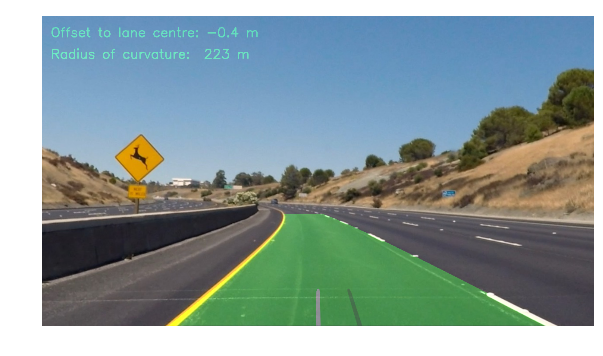

In [30]:
lane_detector = LaneDetector(shape=(1280, 720), mtx=mtx, dist=dist, M=M, Minv=Minv, 
                             fps=25, cutoff=1, 
                             x_pixels_per_metre=x_pixels_per_metre, y_pixels_per_metre=y_pixels_per_metre)
detected_img = lane_detector.update(cv2.imread(test_files[3]))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.imshow(detected_img[:,:,2::-1])
ax.set_axis_off()

fig.savefig('output_images/example_output_frame.png')

## Process video files

In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### project_video.mp4

In [32]:
in_file = 'project_video.mp4'
out_file = 'output_images/project_video.mp4'

clip = VideoFileClip(in_file)
lane_detector = LaneDetector(shape=(1280, 720), mtx=mtx, dist=dist, M=M, Minv=Minv, 
                             fps=25, cutoff=1, 
                             x_pixels_per_metre=x_pixels_per_metre, y_pixels_per_metre=y_pixels_per_metre,
                             color='rgb')

clip_processed = clip.fl_image(lane_detector.update)
%time clip_processed.write_videofile(out_file, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [04:56<00:00,  4.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 13min 26s, sys: 1min 24s, total: 14min 50s
Wall time: 4min 57s


In [33]:
HTML('<video width="960" height="540" controls><source src="{0}"></video>'.format(out_file))

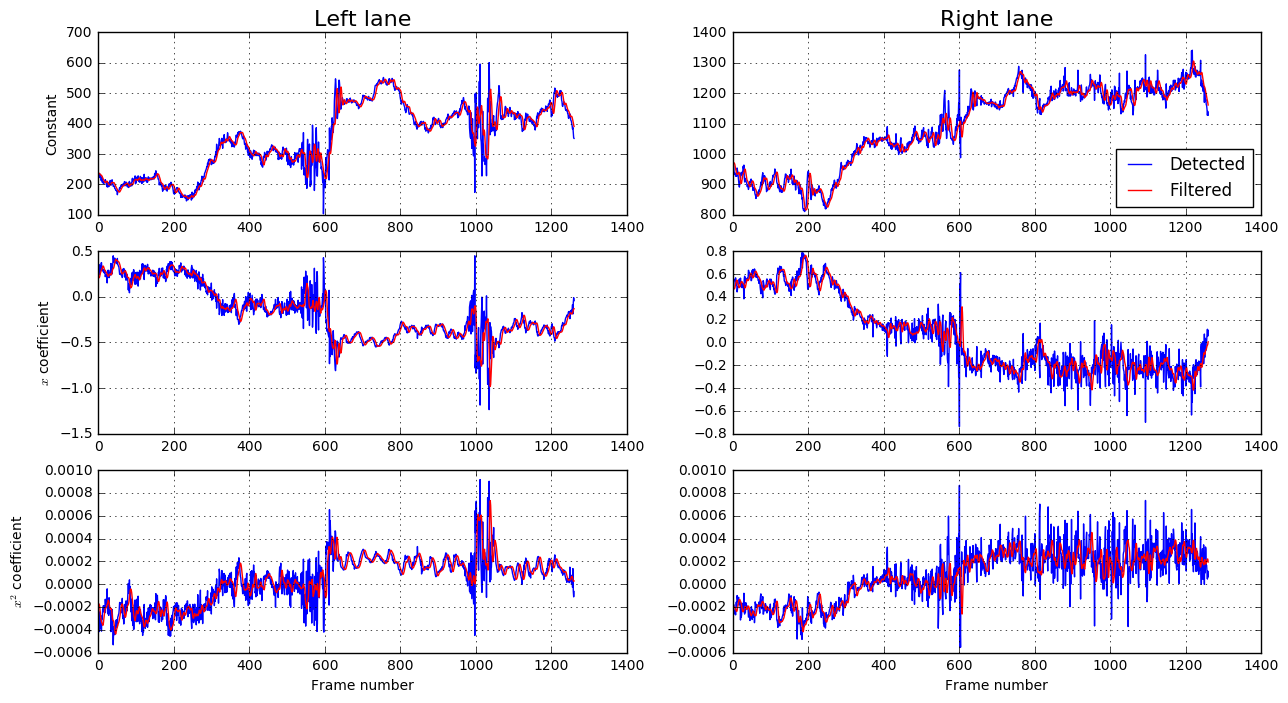

In [34]:
fig = plt.figure(figsize=(15, 8))
# Intercept coefficient
ax = fig.add_subplot(3, 2, 1)
ax.plot(np.array(lane_detector.left_line.history)[:,0], 'b-', label='Detected')
ax.plot(np.array(lane_detector.left_line_filtered.history)[:,0], 'r-', label='Filtered')
ax.grid()
ax.set_ylabel('Constant')
ax.set_title('Left lane', fontsize=16)
ax = fig.add_subplot(3, 2, 2)
ax.plot(np.array(lane_detector.right_line.history)[:,0], 'b-', label='Detected')
ax.plot(np.array(lane_detector.right_line_filtered.history)[:,0], 'r-', label='Filtered')
ax.grid()
ax.legend(loc='lower right')
ax.set_title('Right lane', fontsize=16)

# x coefficient
ax = fig.add_subplot(3, 2, 3)
ax.plot(np.array(lane_detector.left_line.history)[:,1], 'b-', label='Detected')
ax.plot(np.array(lane_detector.left_line_filtered.history)[:,1], 'r-', label='Filtered')
ax.grid()
ax.set_ylabel('$x$ coefficient')
ax = fig.add_subplot(3, 2, 4)
ax.plot(np.array(lane_detector.right_line.history)[:,1], 'b-', label='Detected')
ax.plot(np.array(lane_detector.right_line_filtered.history)[:,1], 'r-', label='Filtered')
ax.grid()

# x**2 coefficient
ax = fig.add_subplot(3, 2, 5)
ax.plot(np.array(lane_detector.left_line.history)[:,2], 'b-', label='Detected')
ax.plot(np.array(lane_detector.left_line_filtered.history)[:,2], 'r-', label='Filtered')
ax.grid()
ax.set_ylabel('$x^2$ coefficient')
ax.set_xlabel('Frame number')
ax = fig.add_subplot(3, 2, 6)
ax.plot(np.array(lane_detector.right_line.history)[:,2], 'b-', label='Detected')
ax.plot(np.array(lane_detector.right_line_filtered.history)[:,2], 'r-', label='Filtered')
ax.grid()
ax.set_xlabel('Frame number')

fig.savefig('output_images/filtering_charts.png')

### challenge_video.mp4

In [36]:
in_file = 'challenge_video.mp4'
out_file = 'output_images/challenge_video.mp4'

clip = VideoFileClip(in_file)
lane_detector = LaneDetector(shape=(1280, 720), mtx=mtx, dist=dist, M=M, Minv=Minv, 
                             fps=25, cutoff=1, 
                             x_pixels_per_metre=x_pixels_per_metre, y_pixels_per_metre=y_pixels_per_metre,
                             color='rgb')

clip_processed = clip.fl_image(lane_detector.update)
%time clip_processed.write_videofile(out_file, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|██████████| 485/485 [01:27<00:00,  5.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

CPU times: user 4min, sys: 21.4 s, total: 4min 21s
Wall time: 1min 29s


In [37]:
HTML('<video width="960" height="540" controls><source src="{0}"></video>'.format(out_file))